# Plot population enriched genes

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_210525_14h42/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## More functions

In [5]:
# I should move this function to rz_functions.py eventually
def get_fc_to_all_other(
    lab,
    meta,
    E,
    pseudo,
    gene_list,
    print_progression = False,
    ):
    
    """
    For each cluster i, find fold-change of a gene in i vs all other cells.
    
    input:
        lab - meta column name to group cell by
        meta - meta dataframe, cells x features
        E - sparse counts, cells x genes, same nr cells as meta
        pseudo - pseudovalue to add
        gene_list - gene list, matches the nr columns of E
        
    output:
        dictionary with cluster names as keys, and pd.Series of genes
        and their fold-change in cluster vs all other cells/
    
    example of use:
        
        
        fcdict = get_fc_to_all_other(
        lab = thelabel,
        meta = meta[cellmask_to_use],
        E = Enorm[cellmask_to_use,:],
        pseudo = pseudo,
        gene_list = gene_list
        )
    
    
    """
    
    resdict = {}
    
    for cl in meta[lab].unique():
        mask = (meta[lab] == cl).values
        maskinv = ~mask

        # selected cells
        left = np.array(E[mask,:].todense())

        # all other cells
        right = np.array(E[maskinv,:].todense())

        # fold-change
        fc = pd.Series((left.mean(axis=0)+pseudo)/(right.mean(axis=0)+pseudo),index=gene_list)
        resdict[cl] = fc
        
        if print_progression:
            print(cl)

    return resdict

# rename for easy code recycling once I move
# the function to 
rz.get_fc_to_all_other = get_fc_to_all_other
del get_fc_to_all_other

## Load data

In [6]:
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_32415x36601_210622_20h17.h5ad')

In [7]:
# load obs with classifier results
adata.obs = rz.load_df('backups/obs_info_32415x18_211010_11h51.npz')

In [8]:
# normalize
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Get enriched genes

### Load color dictionary used in interactive explorer

In [9]:
path1 = "/Users/rapolaszilionis/Google Drive/DG/tmp_for_S3/20210616_RZ_macrophage_fastq_and_counts/quick_analysis_spring_plot/SPRING_dev-master/data/"
project_dir = path1+'/mamito/'
plot_name = 'all_above_900_UMAP_no_cc_2000/'

In [10]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# color dictionary
cdd = {key:value['label_colors'] for key,value in cg0.items()}

### Get centroids

In [11]:
# cell to consider (e.g. pass filter)
cmask = np.repeat(True, adata.shape[0]) #all in this case
print(cmask.sum())

32415


In [12]:
# get centroids
thelabel = 'population'
centroids = rz.centroids(thelabel,adata[cmask])

### Prefilter genes

In [13]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 10
min_cells = 5

In [14]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

11414 genes passing abundance filter


### Statistical testing (+ saving results)

In [15]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups/cluster_vs_rest_MWU_result_dict_%s'%rz.now()
print(fname)
rz.save_stuff(mwu_dict,fname)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
1/9
MA done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
2/9
SS done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
3/9
RS done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
4/9
PA done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
5/9
HA done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
6/9
AI done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
7/9
AII done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
8/9
Dead done 32415
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
9/9
IR done 32415
302.3648998737335
backups/cluster_vs_rest_MWU_result_dict_211010_12h13


In [15]:
# if continuing from backup
mwu_dict = rz.load_stuff('backups/cluster_vs_rest_MWU_result_dict_211010_12h13.pickle')

### Get fold-changes

In [16]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [17]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

population


### Selection of genes to plot

In [18]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]),len(sigmask))

11414
MA 5788 5788 11414
SS 6433 6433 11414
RS 5112 5112 11414
PA 6361 6361 11414
HA 3682 3682 11414
AI 8883 8883 11414
AII 5114 5114 11414
Dead 6493 6493 11414
IR 321 321 11414


In [19]:
# nr genes to consider:
upto = 20

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = list(s.index)+[np.nan]*(upto-len(s))
    frame[key2] = list(s.values)+[0]*(upto-len(s))
    
    frame[str(key)] = np.array(frame[str(key)])
    frame[key2] = np.array(frame[key2])
        
    #verify for fold-change below 1
    mask = np.array(frame[key2])<=1
    if sum(mask)>0:
        print(key,sum(mask),len(mask))
    
    frame[str(key)][mask] = np.nan
    frame[key2][mask] = np.nan

In [20]:
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "_FC" in i]].min() #ok, all above 1.

MA_FC      1.425282
SS_FC      1.711401
RS_FC      1.655435
PA_FC      1.644568
HA_FC      2.252333
AI_FC      1.499946
AII_FC     1.445700
Dead_FC    1.982787
IR_FC      2.011378
dtype: float32

In [21]:
outdir='postannotoutputs/'
fname = outdir+'lists_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
frame.to_excel(fname)

postannotoutputs/lists_enriched_genes_top_20_population_211108_16h27.xlsx


In [22]:
clnames = sorted(fcdictsig.keys())
clnames

['AI', 'AII', 'Dead', 'HA', 'IR', 'MA', 'PA', 'RS', 'SS']

In [23]:
import scipy.cluster

In [24]:
# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))
genes = [i for i in genes if i in adata.var_names] # this is to drop NaNs
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
hierdict = rz.hier_cluster(heat,method='average',metric='correlation')

print(hierdict.keys())

heat = hierdict['data']

180
180
158
dict_keys(['data', 'row_link', 'col_link'])


## Plot a heatmap and dendrogram

### Heatmap

In [40]:
totick = [
'MT-CO3',
'MT-CYB',
'MT-ND1',
'MT-ATP6',
'',
'SNX9',
'STC1',
'ATP2B1',
'',
'IL1B',
'CXCL8',
'CCL3L1',
'CCL3',
'CXCL1',
'CXCL3',
'CSTB',
'MMP8',
'',
'TMEM158',
'TGM2',
'OXR1',
'',
'CTSC',
'TREM2',
'SPP1',
'',
'CD52',
'LMO4',
'',
'IFI6',
'IFITM3',
'CXCL10',
'IFIT1',
'ISG15',
'',
'RPL37A',
'RPS23']

[i for i in totick if i not in genes]

['', '', '', '', '', '', '']

-2.0116014 3.6781251
heatmap_population_upto_20_211010_13h01


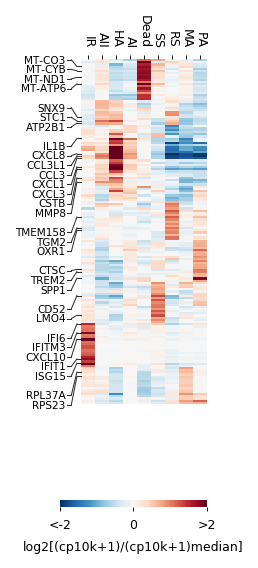

In [42]:
a,fig,gs = rz.startfig(4,10,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-2
vmax=2
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
if len(totick)>0:
    rz.yticks_fancy(a,totick,labels_all = heat.index)
else:
    a.set_yticks([])

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
plt.savefig('postannotoutputs/%s.pdf'%fname,dpi=600)

In [43]:
heat.columns

Index(['IR', 'AII', 'HA', 'AI', 'Dead', 'SS', 'RS', 'MA', 'PA'], dtype='object')

In [45]:
# save the pandas dataframe colored as in the heatmap to excel
rz.color_dataframe_cells(heat,vmin=vmin,vmax=vmax,
                         cmap=mpl.cm.get_cmap('RdBu_r'))

,IR,AII,HA,AI,Dead,SS,RS,MA,PA
index,,,,,,,,,
NEAT1,0,0.164863,-0.268212,-0.605909,1.09551,0.760181,0.0203523,-0.12373,-0.616891
MTRNR2L12,-0.276869,0.253791,-0.0608918,-0.0795878,1.91511,-0.22402,0.441055,0.196574,0
MALAT1,0,-0.151972,-0.899275,-0.304742,1.57246,0.675171,0.152034,0.221255,-0.282828
MT-CO3,0,0.187013,-0.588152,-0.369879,1.79569,0.471345,-0.0837547,0.403845,-0.336656
MT-ND3,0.0600144,0.135126,-0.503393,-0.49514,1.66828,0.292363,-0.389527,0,-0.662225
MT-CYB,0,0.354617,-0.403006,-0.312978,1.74652,0.579659,-0.000233743,0.298152,-0.420078
MT-ND2,0,0.149552,-0.523581,-0.43321,1.78505,0.32185,-0.157625,0.0894477,-0.563592
MT-ND4,-0.0383116,0.290103,-0.4412,-0.369508,1.71551,0.295075,0,0.147187,-0.519524
MT-ND1,0,0.280045,-0.499677,-0.429051,1.82379,0.337171,-0.0783416,0.239156,-0.511469


In [46]:
# save the pandas dataframe colored as in the heatmap to excel
rz.color_dataframe_cells(heat,vmin=vmin,vmax=vmax,
                         cmap=mpl.cm.get_cmap('RdBu_r')).to_excel('postannotoutputs/heatmap_order_%s.xlsx'%fname)

In [62]:
!open postannotoutputs/

### Dendrogram

postannotoutputs//dendrogram_population_211010_13h02.pdf


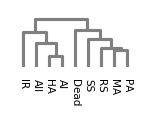

In [47]:
a,fig,gs = rz.startfig(2.5,2)
col_link = hierdict['col_link']
dendro = scipy.cluster.hierarchy.dendrogram(
                                 col_link, orientation='top', ax=a,
                                 above_threshold_color='0.5',
                                 color_threshold = 0,
                                    )

a.set_xticklabels(heat.columns,rotation=270,fontsize=5)
a.set_yticks([])

rz.showspines(a)

gs.tight_layout(fig)
fname = 'postannotoutputs//dendrogram_%s_%s.pdf'%(thelabel,rz.now())
print(fname)
plt.savefig(fname)

In [49]:
!open postannotoutputs/

In [27]:
# print colors to have handy
cdd['condition']

{'Control': '#ffe500', 'KIPyV VLPs': '#00d4ff', 'MCPyV VLPs': '#00007f'}

In [28]:
cdd['phase']

{'G0': '#008080', 'G1S': '#FFAE00', 'G2M': '#FF0000'}

In [29]:
cdd['population']

{'AI': '#5eff0d',
 'AII': '#49a300',
 'Dead': '#ff9900',
 'HA': '#114a0e',
 'IR': '#ff0000',
 'MA': '#00007f',
 'PA': '#fff757',
 'RS': '#0088ff',
 'SS': '#0cf4e8'}